<a href="https://colab.research.google.com/github/jr008489900/ActionScript3/blob/master/Earth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#安裝需要用到的連結庫


In [0]:

#to access kaggle datasets
!pip install kaggle
#Math operations
!pip install numpy==1.15.0
#Machine learning
!pip install catboost



In [0]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#machine learning
from catboost import CatBoostRegressor, Pool
#data scaling
from sklearn.preprocessing import StandardScaler
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV
#support vector machine model
from sklearn.svm import NuSVR, SVR
#kernel ridge model
from sklearn.kernel_ridge import KernelRidge
#data visualization
import matplotlib.pyplot as plt

In [2]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [3]:
#list competitions
!kaggle competitions list

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                   2030-01-01 00:00:00  Getting Started  Knowledge       3080           False  
titanic                                            2030-01-01 00:00:00  Getting Started  Knowledge      11105           False  
house-prices-advanced-regression-techniques        2030-01-01 00:00:00  Getting Started  Knowledge       4744           False  
imagenet-object-localization-challenge             2029-12-31 07:00:00  Research         Knowledge         41           False  
competitive-data-science-predict-future-sales      2019-12-31 23:59:00  Playground           Kudos       3409           False  
open-images-2019-object-detection                  2019-10-01 23:59:00  Research           $25,000      

In [4]:
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 25.0MB/s]
 98% 237M/242M [00:02<00:00, 137MB/s]
100% 242M/242M [00:02<00:00, 118MB/s]
 99% 2.01G/2.03G [00:20<00:00, 60.8MB/s]
100% 2.03G/2.03G [00:20<00:00, 107MB/s] 


In [0]:
!unzip -q -o test.zip -d test.csv
!unzip -q -o train.csv.zip -d train.csv

In [0]:
#Extract training data into a dataframe for further manipulation
train = pd.read_csv('./train.csv/train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [7]:
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


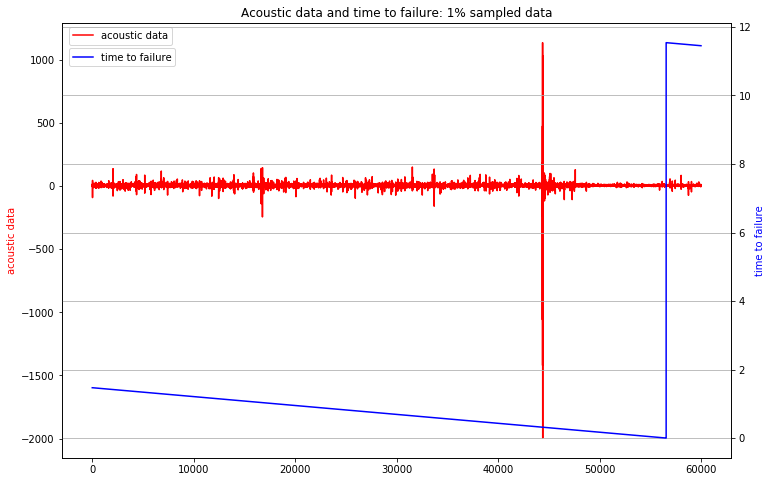

In [8]:


#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df



# 產生feature，一共有114個特徵~


In [0]:
# Step 4 - Feature Engineering and signifiance of these statistical features

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from tqdm import tqdm, tqdm_notebook
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor
from sklearn.model_selection import KFold, cross_validate, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import stats

#lets create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    
    strain.append()
    
    return pd.Series(strain)
  
def test_features(segment, seg, X_tr):
  
    x = pd.Series(seg['acoustic_data'].values)
    X_tr.loc[segment, 'mean'] = x.mean()
    X_tr.loc[segment, 'std'] = x.std()
    X_tr.loc[segment, 'max'] = x.max()
    X_tr.loc[segment, 'min'] = x.min()
  
def create_features(segment, seg, X_tr):
  
    x = pd.Series(seg['acoustic_data'].values)
    X_tr.loc[segment, 'mean'] = x.mean()
    X_tr.loc[segment, 'std'] = x.std()
    X_tr.loc[segment, 'max'] = x.max()
    X_tr.loc[segment, 'min'] = x.min()
    
    X_tr.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
#     X_tr.loc[segment, 'mean_change_rate'] = calc_change_rate(x)
    X_tr.loc[segment, 'abs_max'] = np.abs(x).max()
    X_tr.loc[segment, 'abs_min'] = np.abs(x).min()
    
    X_tr.loc[segment, 'std_first_50000'] = x[:50000].std()
    X_tr.loc[segment, 'std_last_50000'] = x[-50000:].std()
    X_tr.loc[segment, 'std_first_10000'] = x[:10000].std()
    X_tr.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
    X_tr.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    X_tr.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    X_tr.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    X_tr.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
    X_tr.loc[segment, 'min_first_50000'] = x[:50000].min()
    X_tr.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X_tr.loc[segment, 'min_first_10000'] = x[:10000].min()
    X_tr.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
    X_tr.loc[segment, 'max_first_50000'] = x[:50000].max()
    X_tr.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X_tr.loc[segment, 'max_first_10000'] = x[:10000].max()
    X_tr.loc[segment, 'max_last_10000'] = x[-10000:].max()
    
    #X_tr.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    X_tr.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_tr.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])
    X_tr.loc[segment, 'sum'] = x.sum()
    
#     X_tr.loc[segment, 'mean_change_rate_first_50000'] = calc_change_rate(x[:50000])
#     X_tr.loc[segment, 'mean_change_rate_last_50000'] = calc_change_rate(x[-50000:])
#     X_tr.loc[segment, 'mean_change_rate_first_10000'] = calc_change_rate(x[:10000])
#     X_tr.loc[segment, 'mean_change_rate_last_10000'] = calc_change_rate(x[-10000:])
    
    X_tr.loc[segment, 'q95'] = np.quantile(x, 0.95)
    X_tr.loc[segment, 'q99'] = np.quantile(x, 0.99)
    X_tr.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X_tr.loc[segment, 'q01'] = np.quantile(x, 0.01)
    
    X_tr.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_tr.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_tr.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_tr.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
#     X_tr.loc[segment, 'trend'] = add_trend_feature(x)
#     X_tr.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_tr.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_tr.loc[segment, 'abs_std'] = np.abs(x).std()
    
    X_tr.loc[segment, 'mad'] = x.mad()
    X_tr.loc[segment, 'kurt'] = x.kurtosis()
    X_tr.loc[segment, 'skew'] = x.skew()
    X_tr.loc[segment, 'med'] = x.median()
    
#     X_tr.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
#     X_tr.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
#     X_tr.loc[segment, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
#     X_tr.loc[segment, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
#     X_tr.loc[segment, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
#     X_tr.loc[segment, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
#     X_tr.loc[segment, 'classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
#     X_tr.loc[segment, 'classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
#     X_tr.loc[segment, 'classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
#     X_tr.loc[segment, 'classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
    X_tr.loc[segment, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_tr.loc[segment, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_30000_mean'] = ewma(x, span=30000).mean().mean(skipna=True)
    no_of_std = 3
    X_tr.loc[segment, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_tr.loc[segment,'MA_700MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment,'MA_700MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_tr.loc[segment,'MA_400MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment,'MA_400MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    X_tr.drop('Moving_average_700_mean', axis=1, inplace=True)
    
    X_tr.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_tr.loc[segment, 'q999'] = np.quantile(x,0.999)
    X_tr.loc[segment, 'q001'] = np.quantile(x,0.001)
    X_tr.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)

    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_tr.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_tr.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_tr.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_tr.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_tr.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_tr.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_tr.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_tr.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        #X_tr.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_tr.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_tr.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_tr.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_tr.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_tr.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_tr.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_tr.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_tr.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        #X_tr.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
  

In [0]:


train = pd.read_csv('./train.csv/train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()

"""
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
    
"""
temp=0
for df in train:
  ch=create_features(temp,df,X_train)
  X_train.append(ch, ignore_index=True)
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
  temp=temp+1



In [0]:
from tqdm import tnrange, tqdm_notebook
from sklearn.preprocessing import StandardScaler 

# Reading testing data

In [12]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_train.columns,index=submission.index,dtype=np.float64)
plt.figure(figsize=(22, 16))
scaler = StandardScaler()
scaler.fit(X_train)
temp=0
for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv('test.csv/' + seg_id + '.csv')
    create_features(seg_id,seg, X_test)
    """
    x = pd.Series(seg['acoustic_data'].values)
    X_test.loc[seg_id, 'mean'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'min'] = x.max()
    X_test.loc[seg_id, 'max'] = x.min()
    X_test.loc[seg_id, 'kurtosis'] = x.kurtosis()
    X_test.loc[seg_id, 'skew'] = x.skew()
    X_test.loc[seg_id, 'q01'] = np.quantile(x,0.01)
    X_test.loc[seg_id,'q05'] = np.quantile(x,0.05)
    X_test.loc[seg_id, 'q95'] = np.quantile(x,0.95)
    X_test.loc[seg_id, 'q99'] = np.quantile(x,0.99)
    X_test.loc[seg_id, 'abs_max'] = np.abs(x).mean()
    X_test.loc[seg_id, 'abs_mean'] = np.abs(x).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(x).std()
    """
    
"""
    seg = train_data.iloc[seg_id*segment_size:seg_id*segment_size+segment_size]
    create_features(seg_id, seg, X_train)
     y_train.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]
"""    
    
    

"\n    seg = train_data.iloc[seg_id*segment_size:seg_id*segment_size+segment_size]\n    create_features(seg_id, seg, X_train)\n     y_train.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]\n"

<Figure size 1584x1152 with 0 Axes>


# Scaling the training data


In [0]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_train_scaled

In [0]:
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [18]:


#Model #1 - Catboost

train_pool = Pool(X_train_scaled, y_train)
m = CatBoostRegressor(iterations=10000, learning_rate=0.01 , depth=5 ,loss_function='RMSE', boosting_type='Ordered')
m.fit(X_train_scaled, y_train, silent=True)
m.best_score_



{'learn': {'RMSE': 1.99787508704372}}

In [19]:
# Catboost-Predict
Cat_y_test=m.predict(X_test_scaled)
print(Cat_y_test)

[ 2.51712932  5.68758091  4.58965493 ...  4.22724509  1.70568868
 10.08333927]


In [0]:
#EXPAND-DATA
import numpy as np
x_train = X_train_scaled.values.reshape((X_train.shape[0],1,X_train.shape[1]))
x_test = X_test_scaled.values.reshape((X_test.shape[0],1,X_test.shape[1]))

# 建構3個RNN模型

In [23]:


#Model #3 - RNN

import matplotlib.pyplot as plt
import numpy as np
import time
import csv
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout , Flatten
from keras.layers.recurrent import LSTM
from keras import optimizers
np.random.seed(2017)

def build_model1():
    
    model = Sequential()
    layers = [1, 256, 512, 1]
    model.add(LSTM(
            layers[1],
            input_shape=(1, 114),
            return_sequences=True))
    
    model.add(LSTM(layers[2] , return_sequences=True))
    
    model.add(Flatten())
    
    model.add(Dense(64,activation = 'tanh'))
    
    model.add(Dense(
            layers[3]))
    
    start = time.time()
    model.compile(loss="mean_squared_error", optimizer='RMSprop')
    model.summary()
    print("Compilation Time : ", time.time() - start)
    return model
    



Using TensorFlow backend.


In [0]:
#model3 - RNN2

from keras.layers import TimeDistributed
def build_model2():
    model = Sequential()
    model.add(LSTM(256, input_shape=(1,114), return_sequences=True))
    model.add(LSTM(512, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(5,activation='relu'))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam",metrics=['mean_squared_error'])
    model.summary()
    return model

In [0]:
#model4 - RNN3 GRU

from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Conv2D, Conv3D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam , RMSprop


def build_model3():
    
    model = Sequential()
    model.add(GRU(256, input_shape=(1,114), return_sequences=True,dropout=0.2))
    model.add(GRU(512, return_sequences=True,dropout=0.2))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(5,activation='relu'))
    model.add(Dense(1))
    
    opt = RMSprop(lr=0.001)
    model.compile(loss='mae', optimizer=opt, metrics=["mae"])
    
    model.summary()
    return model

# 開始訓練模型~~~

In [26]:
model1 = build_model1()
model1.fit(
          x_train,y_train,
          batch_size=100, epochs=30,validation_split=0.1)


W0616 19:10:05.396773 140193543714688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0616 19:10:05.436295 140193543714688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0616 19:10:05.448014 140193543714688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0616 19:10:06.559014 140193543714688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 256)            379904    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 512)            1574912   
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,987,713
Trainable params: 1,987,713
Non-trainable params: 0
_________________________________________________________________
Compilation Time :  0.03596043586730957


W0616 19:10:06.830186 140193543714688 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0616 19:10:07.932637 140193543714688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0616 19:10:07.939817 140193543714688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 3775 samples, validate on 420 samples
Epoch 1/30
3775/3775 [==============================] - 5s 1ms/step - loss: 13.7893 - val_loss: 5.6717
Epoch 2/30
3775/3775 [==============================] - 0s 103us/step - loss: 7.7788 - val_loss: 5.7866
Epoch 3/30
3775/3775 [==============================] - 0s 99us/step - loss: 7.4848 - val_loss: 4.3292
Epoch 4/30
3775/3775 [==============================] - 0s 101us/step - loss: 7.3342 - val_loss: 5.1515
Epoch 5/30
3775/3775 [==============================] - 0s 97us/step - loss: 7.3228 - val_loss: 4.9375
Epoch 6/30
3775/3775 [==============================] - 0s 97us/step - loss: 7.2798 - val_loss: 5.6643
Epoch 7/30
3775/3775 [==============================] - 0s 98us/step - loss: 7.1702 - val_loss: 6.2465
Epoch 8/30
3775/3775 [==============================] - 0s 95us/step - loss: 7.1655 - val_loss: 5.8238
Epoch 9/30
3775/3775 [==============================] - 0s 95us/step - loss: 7.1415 - val_loss: 6.4532
Epoch 10/30
3775/3775 [=

In [27]:
model2 = build_model2()
model2.fit(
          x_train,y_train,
          batch_size=100, epochs=30,validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 256)            379904    
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 512)            1574912   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 1)              513       
_________________________________________________________________
flatten_2 (Flatten)          (None, 1)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 10        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 1,955,345
Trainable params: 1,955,345
Non-trainable params: 0
_________________________________________________________________


In [28]:
model3 = build_model3()
model3.fit(
          x_train,y_train,
          batch_size=100, epochs=30,validation_split=0.1)

W0616 19:10:40.130657 140193543714688 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 1, 256)            284928    
_________________________________________________________________
gru_2 (GRU)                  (None, 1, 512)            1181184   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 1)              513       
_________________________________________________________________
flatten_3 (Flatten)          (None, 1)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 10        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 6         
Total params: 1,466,641
Trainable params: 1,466,641
Non-trainable params: 0
_________________________________________________________________


# 預測以及測試

In [0]:
y_test1 = model1.predict(x_test)
y_test2 = model2.predict(x_test)
y_test3 = model3.predict(x_test)

In [213]:
#result=(pd.DataFrame(RNN_y_test)+pd.DataFrame(RNN_y_test2)+pd.DataFrame(GRU_y_test))/3
result=(RNN_y_test+RNN_y_test2+GRU_y_test)/3
print(result)



#print(submission)

[[0.8897795 ]
 [0.92382646]
 [0.47280523]
 ...
 [0.40906048]
 [0.9910957 ]
 [1.0298575 ]]


In [0]:
# import the modules we'll need
from IPython.display import HTML
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

submission['time_to_failure'] = (y_test1+y_test2+y_test3)/3

In [43]:
create_download_link(submission)